In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [34]:
t = np.linspace(-10, 10, 1000) #time
dt = (np.max(t) - np.min(t)) / len(t)

now = 0
past = -5
future = 2.5

In [35]:
def where(t, x):
    diffs = np.abs(t - x)
    return np.min(np.where(diffs == np.min(diffs))[0])

In [48]:
def decay(x, n, dt, tau):
    #x: initial value
    #n: number of timesteps
    #dt: change in time per timestep
    #tau: decay rate
    
    y = np.zeros(n)
    y[0] = x
    
    for i in range(1, n):
        y[i] = (1 - dt) * tau * (y[i - 1])
    return y

In [70]:
#context: thoughts now are a recency-weighted blend of prior moments
context = np.zeros_like(t)
tau = 0.95

context[0:where(t, now)] = decay(1, where(t, now), dt, tau)[::-1]

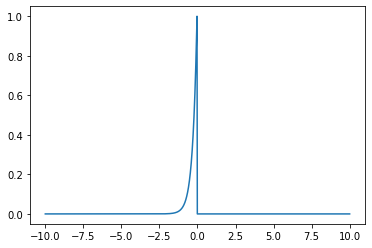

In [71]:
plt.plot(t, context)

0.002